# PHY1024 - Introduction to Python Programming, week 5

The lecture materials, worksheets, and assignments can all be found here:

http://go.qub.ac.uk/phy1024y2016


## Lecture materials

Note: today at the end of this lecture the Teaching Evaluation forms will be handed out. Please complete the forms, and I will ask one of you to bring them to the M&P office where you also handed in your Assignments.

Note: the computer labs sessions are mandatory also in weeks where there is no new assignment. Attendance sheets will be provided for the computer labs which need to be signed by each student either on a Thursday session or a Friday session.

### How to actually find the best fit in nontrivial situations

In the last week we have looked at the concept of the chi-squared statistic as a measure for the goodness of fit. Smaller chi-squared values indicate a better fit.

In the computer labs, we have also looked at an example of an exoplanet transit, and particularly the transit-timing variation. We tried to find the time shift of an observed exoplanet transit compared to an expected transit start time.

Today we will use the same example to learn about algorithms that try to find the best fit in a fairly efficient manner.

A reminder, we're looking at this problem here:

Image credit: K. Poppenhaeger


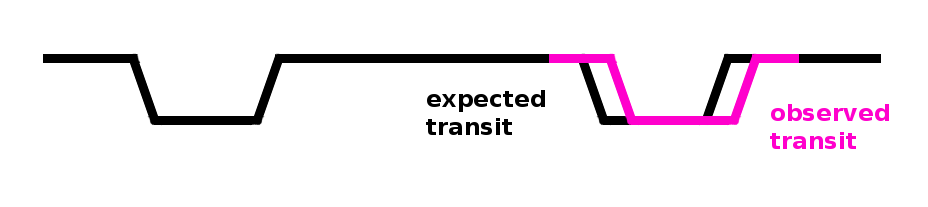

In [2]:
import numpy as np
import matplotlib.pyplot as plt
# the next line is only for ipython notebooks:
%matplotlib inline
from IPython.display import Image
print 'Image credit: K. Poppenhaeger'
Image(filename='TTV_KP.png', width=800) 

We will use a simplified version where there is no gradual decline and rise at the beginning and end of the transit, but just a sudden drop from one instant to the next.

That means this is what our expected transit looks like:

[0, 30, 0.8, 1.1]

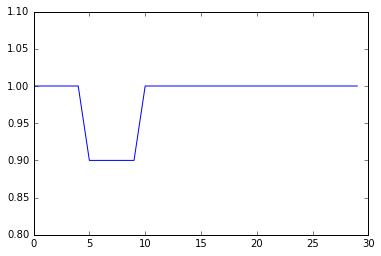

In [106]:
t = np.arange(0, 30)
# expected transit model
transit_expected = np.ones(len(t))
# setting the bottom of the transit to 0.9
transit_expected[5:10] = 0.9

plt.figure()
plt.plot(t, transit_expected, '-')
plt.axis([0, 30, 0.8, 1.10])

And say we have some observational data, with the transit occurring at some time stamp, but not necessarily where we expect it:

[0, 30, 0.8, 1.1]

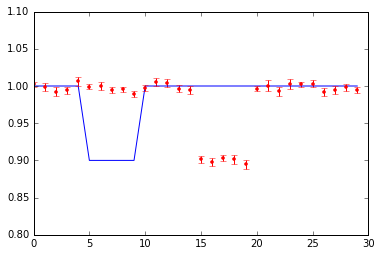

In [107]:
y = np.ones(len(t))
# setting the bottom of the transit to 0.9
y[15:20] = 0.9
# add some random noise to the data:
np.random.seed(123456)
y = y + np.random.normal(0, 0.005, len(t))
# define some error bars for the data:
e = 0.005 + np.random.normal(0, 0.001, len(t))

plt.figure()
plt.plot(t, transit_expected)
plt.errorbar(t, y, e, fmt = 'r.')
plt.axis([0, 30, 0.8, 1.10])

We can now test all possible start times for a transit and calculate how well the model fits the data, using the chi-square statistic.

Quick reminder:

This is how to calculate the chi-squared statistic:

## $\chi^2 = \Sigma \frac{(y_i - f(x_i))^2}{\sigma^2_i}$

And this is how to calculate the "reduced chi-squared", which is basically chi-squared divided by the number of data points. (Precisely, it's the number of "degrees of freedom" which is the number of data points minus the number of parameters we are trying to fit. We are trying to fit one parameter, namely the transit start time, so in our case it's "number of data points minus one".)

## $\chi^2_{reduced} = \frac{1}{N-1} \Sigma \frac{(y_i - f(x_i))^2}{\sigma^2_i}$

The models that fit the data well will have a smaller value for chi-squared (and reduced chi-squared), the ones that don't fit well will have a larger one.

In [108]:
# function for the shifted transit model:

def transit_model(t_start):
    # number of data points in our specific example:
    N = 30
    # duration of transit, measured in time steps, for our example:
    duration = 5
    # make model with no transit in it:
    model = np.ones(N)
    # insert transit at corret location in the model array,
    # depending on the start time:
    model[t_start:t_start+duration] = 0.9
    return model

# function to calculate chi-squared:

def calc_chisquared(data, errors, model):
    # in Python we don't need to do this element by element,
    # but we can just use the full arrays!
    chisq = ((data - model)**2/errors**2).sum()
    return chisq


# all possible start times in our time window: 0 to 80.

start = np.arange(0, 25)
chisq = np.zeros(len(start))


for i in np.arange(0, len(start)):
    model = transit_model(start[i])
    chisq[i] = calc_chisquared(y, e, model)


I'm plotting a few models with different start times together with the data; you can see by eye that the blue model is a pretty bad fit, the red (dashed) one is a very good fit, and the green (dotted) one is an okay-ish fit.

The second plot shows that reduced chi-squared of those three models as a function of their transit start times. We can see (as expected) that the red model has the smallest reduced chi-squared.

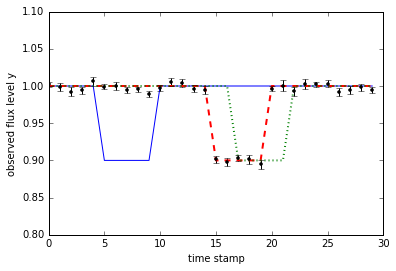

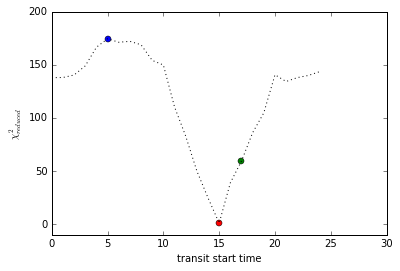

In [109]:
my_transit_starttimes = np.array([5, 15, 17])

model_1 = transit_model(my_transit_starttimes[0])
model_2 = transit_model(my_transit_starttimes[1])
model_3 = transit_model(my_transit_starttimes[2])

# plot of data and 3 models
plt.figure()
plt.plot(t, model_1, 'b-')
plt.plot(t, model_2, 'r--', lw=2)
plt.plot(t, model_3, 'g:', lw=2)
plt.errorbar(t, y, e, fmt = 'k.')
plt.ylabel('observed flux level y')
plt.xlabel('time stamp')
plt.axis([0, 30, 0.8, 1.10])

# plot of the reduced chi-squared of the 3 models
plt.figure()
plt.plot(my_transit_starttimes[0], calc_chisquared(y, e, model_1)/(len(y)-1), 'bo')
plt.plot(my_transit_starttimes[1], calc_chisquared(y, e, model_2)/(len(y)-1), 'ro')
plt.plot(my_transit_starttimes[2], calc_chisquared(y, e, model_3)/(len(y)-1), 'go')
# plot of all reduced chi-squared values for all possible start times (calculated farther above)
plt.plot(start, chisq/(len(y)-1), 'k:')
plt.axis([0, 30, -10, 200])
plt.xlabel('transit start time')
plt.ylabel('$\chi^2_{reduced}$')


Now this calculation is fairly easy, because we only calculate the reduced chi-squared for a small number of start times (25 in this example). But if we have a very large data set, or we want to find the best-fitting parameter to a large accuracy, it will take  a very long time for an algorithm to just test all possibilities by brute force.

For many real-world problems, a brute-force approach isn't even going to find the best result, because the quantity we want to fit may not be changing step-wise. (Imagine for our example that the actual transit starts somewhere *between* two time stamps - all of a sudden we have a continuous parameter space that we need to seach for the best fit.)

The way to deal with this is using algorithms that are somewhat clever in actually finding the best fit. One such example is the Simplex Fit.

### Simplex fits

First of all, what is a simplex?

A simplex is a geometric entity which has one more corner than the space it is defined in has dimensions.

What does this mean? Basically, a simplex is a triangle. All the fancy language is just there to describe the appropriate generalizations for cases where we are not dealing with a 2-dimensional plane (in which triangles live).

So, in 2-D, a simplex has 3 corners and is therefore a triangle.

In 3-D, a simplex has 4 corners and is a tetrahedron.

In 1-D, a simplex has 2 corners and is therefore a line segment.

In 0-D, a simplex has 1 corner and is therefore a dot.



What do we use a simplex for when we try to fit a function to data? We can use it to "go downwards" to the minimum of the chi-squared statistic.

Let's say we have some transit start time that describes the data best, and if we test a lot of models with different transit start times against the data, we see (as above) that we will find the best-fitting model at the start time where the chi-squared is the lowest.

Let's say our chi-squared versus transit start time looks like this:


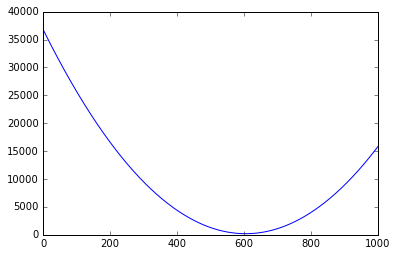

In [139]:
t = np.arange(1, 1000, 0.1)

# I made up some polynomial function here just to get a nice shape for my example chi-squared plot.
def my_chi_func(t):
    return 800 + -t + 0.1*(t-600)**2

chi2 = my_chi_func(t)

plt.figure()
plt.plot(t, chi2)

We want to write an algorithm that starts calculating the chi-squared value at some initial point, i.e. some random guess for the transit start time, and then progressively walks downwards into the minimum of this chi-squared plot. When the algorithm finds the bottom of this, we want it to stop and give us the result it found. This will be our best-fitting transit start time.

Now the trick is: to make this plot, I had to calculate all those values that make up the plot, i.e. I did exactly the thing we want to avoid: having to calculate the chi-squared for many models. 

We want our algorithm to calculate a few points, like the red dots in the plot below, and then make a good guess in which direction it should go with its next guess, without the algorithm knowing what the chi-squared function, plotted as the grey dashed line, actually looks like:


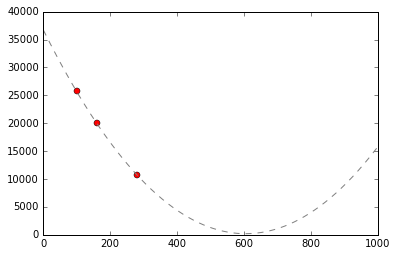

In [142]:
t_guess_1 = 100
t_guess_2 = 160
t_guess_3 = 280

plt.figure()
plt.plot(t_guess_1, my_chi_func(t_guess_1), 'ro')
plt.plot(t_guess_2, my_chi_func(t_guess_2), 'ro')
plt.plot(t_guess_3, my_chi_func(t_guess_3), 'ro')

plt.plot(t, chi2, '--', color='grey')

The method how to do this with simplices is this:

In our example, the chi-squared function is a one-dimensional curve. This is because we are only fitting one parameter in our problem (the trasnit start time). (If we had two parameters to fit, the chi-squared function would be a two-dimenional plane, like a topographic map.)

Because of the one-dimensional chi-squared function, we use a simplex in 1-D, which is a line segment.

We will make a simplex (a line) out of the two best two red data points, and try to find a better option for the third data point to make a new simplex and make it "walk" into the minimum.

A possible algorithm goes like this (this is the so-called Nelder-Mead simplex algorithm):

**Step 1)** Randomly choose 3 values t1, t2, t3 for the model (i.e. 3 transit start times) and calculate their chi-squared values.

**Step 2)** Sort the points in ascending order of chi-squared value, so that t1 has the lowest chi-squared, and t3 has the largest.

**Step 3)** Calculate the "centroid" between the two best points (i.e. the middle between t1 and t2) and call it tc.

**Step 4)** Use the point t3 for "walking": we *reflect* the worst point (t3) to the other side of tc, call this point t4. Calculate the chi-squared for t4.

**Step 5)** Compare $\chi^2$(t4) to $\chi^2$(t1), $\chi^2$(t2), and $\chi^2$(t3). This comparison determines the next step. Depending on which 3 points we chose in the beginning, the following options can occur:

**A)** If t4 is better than t1, but worse than t2: i.e. $\chi^2$(t1) < $\chi^2$(t4) < $\chi^2$(t2) < $\chi^2$(t3).

In that case throw away t3 and keep t4. Make new simplex out of t1 and t4, t2 is the new walking point. Start over at Step 2. (Rename points accordingly).


Image credit: K. Poppenhaeger


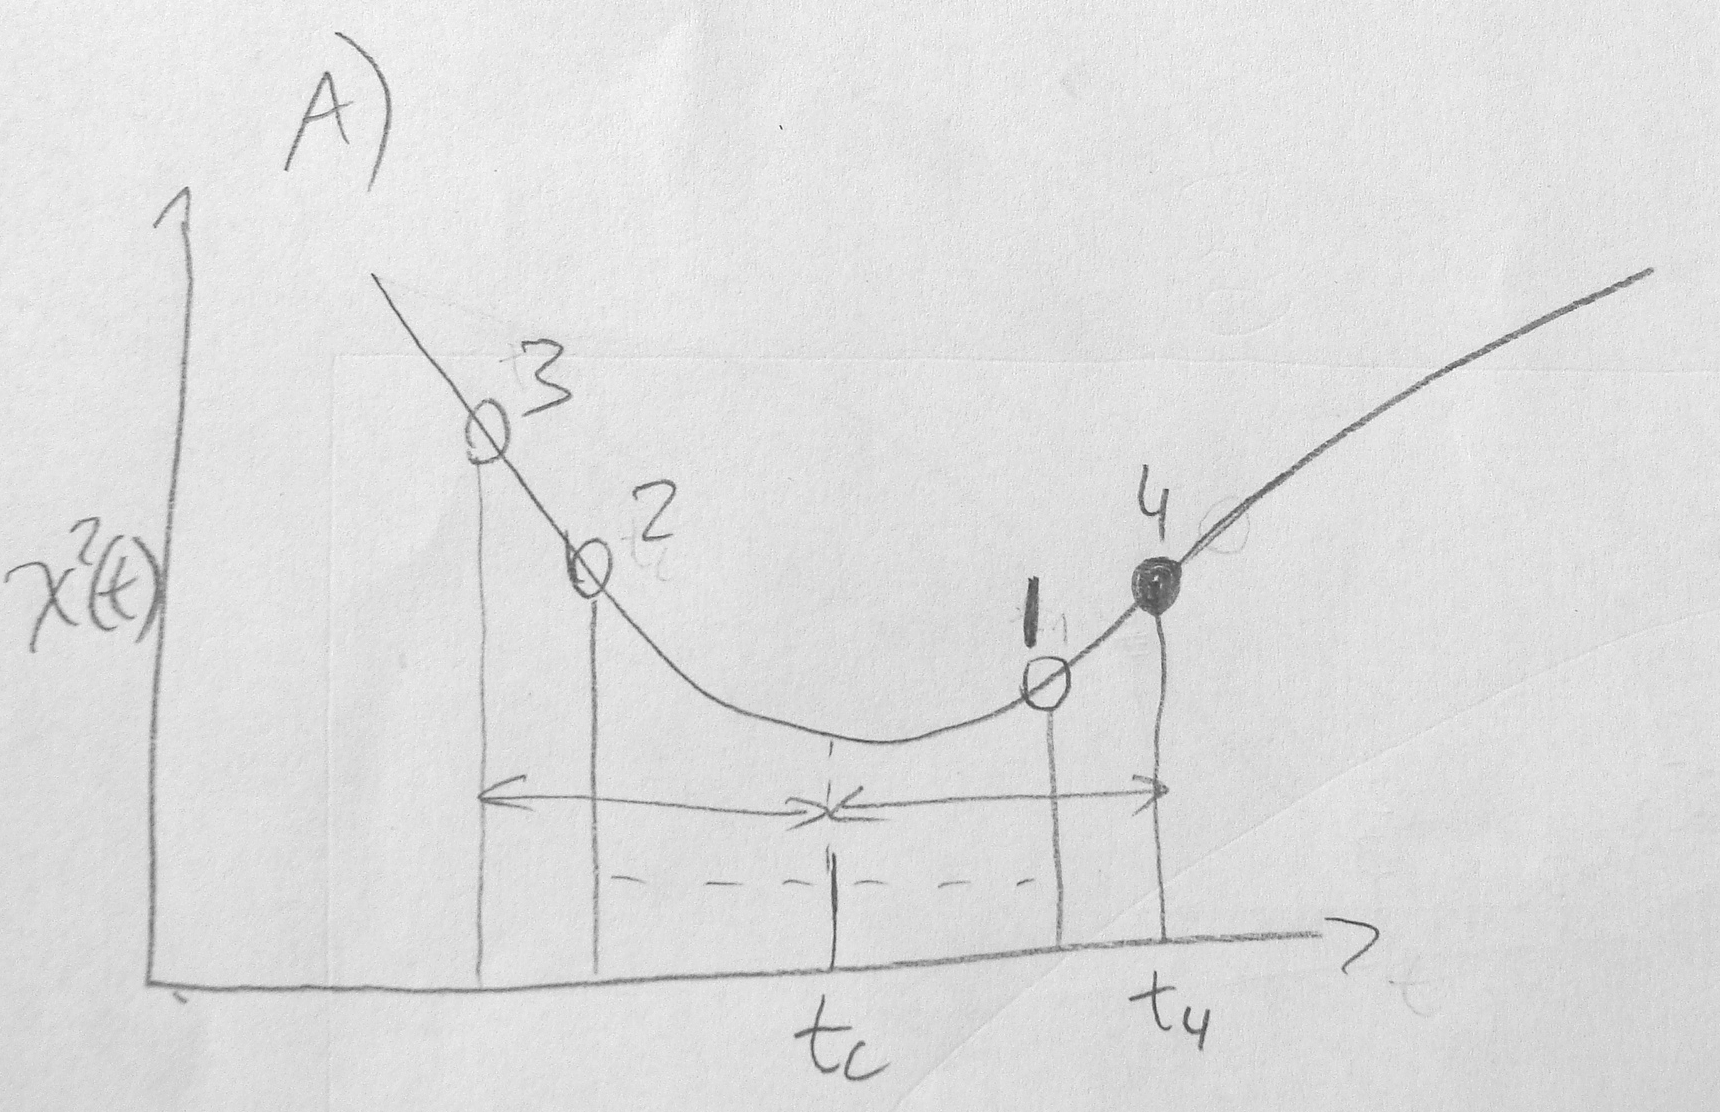

In [143]:
print 'Image credit: K. Poppenhaeger'
Image(filename='simplexA.JPG', width=800) 

**B)** If t4 is better than all the other 3 points: i.e. $\chi^2$(t4) < $\chi^2$(t1) < $\chi^2$(t2) < $\chi^2$(t3).

In that case we're obviously going in the correct direction with our new point t4, so we might as well try to go into that direction a bit farther.

We make another point t5, which is *twice* as far from the centroid point tc and see if that's even better than t4. 

Keep whichever one is better and discard t3.

Make new simplex out of whichever point we kept and t1, t2 is the new walking point. Start over at Step 2 (rename points accordingly).

Image credit: K. Poppenhaeger


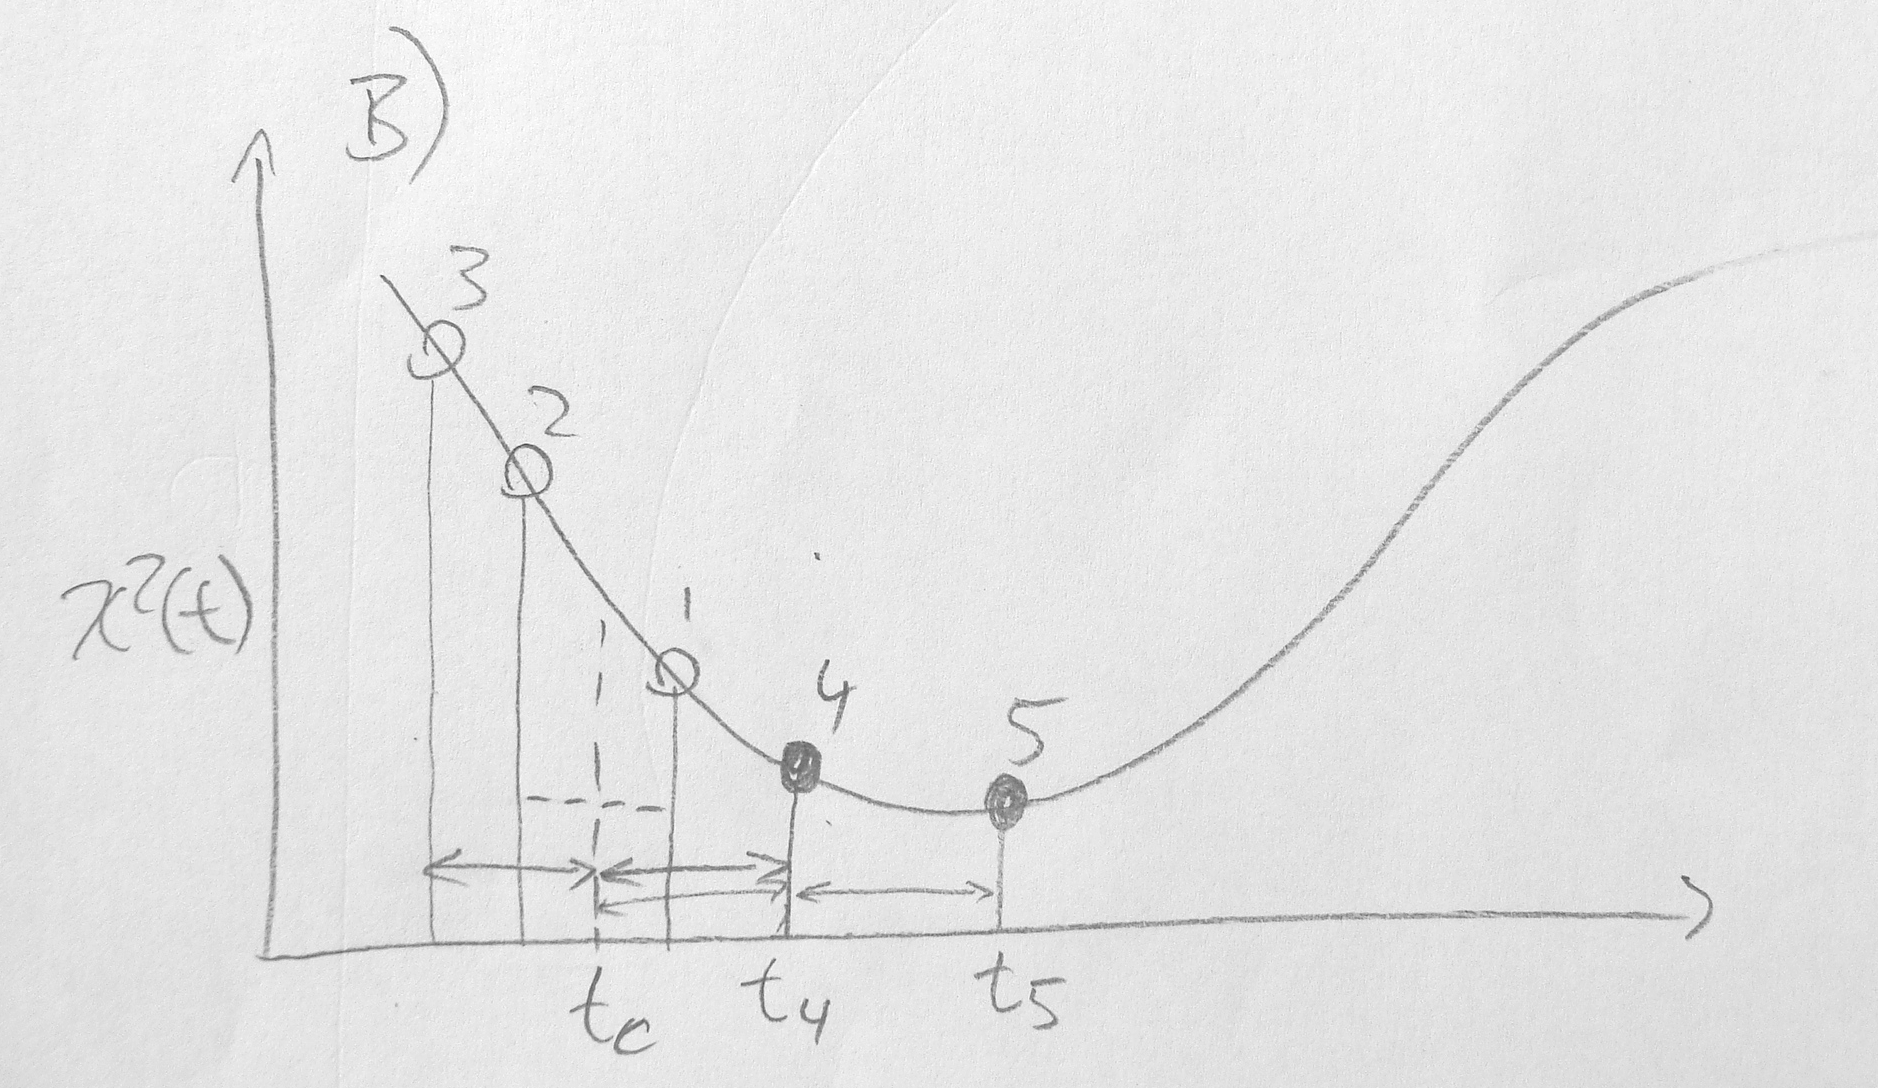

In [144]:
print 'Image credit: K. Poppenhaeger'
Image(filename='simplexB.JPG', width=800) 

**C)** If t4 is worse than t1 and t2, but better than t3: i.e. $\chi^2$(t1) < $\chi^2$(t2) < $\chi^2$(t4) < $\chi^2$(t3).

In that case the minimum is probably somewhere between t3 and t4. We try to find a better point t5 by going only *half* the distance between tc and t4. 

If t5 is better than t2: keep t5, discard t4 and t3, make new simplex out of t5 and t1, t2 is the new walking point. Start over at Step 2 (rename points accordingly).

If t5 is still worse than t3: go to option D.

Image credit: K. Poppenhaeger


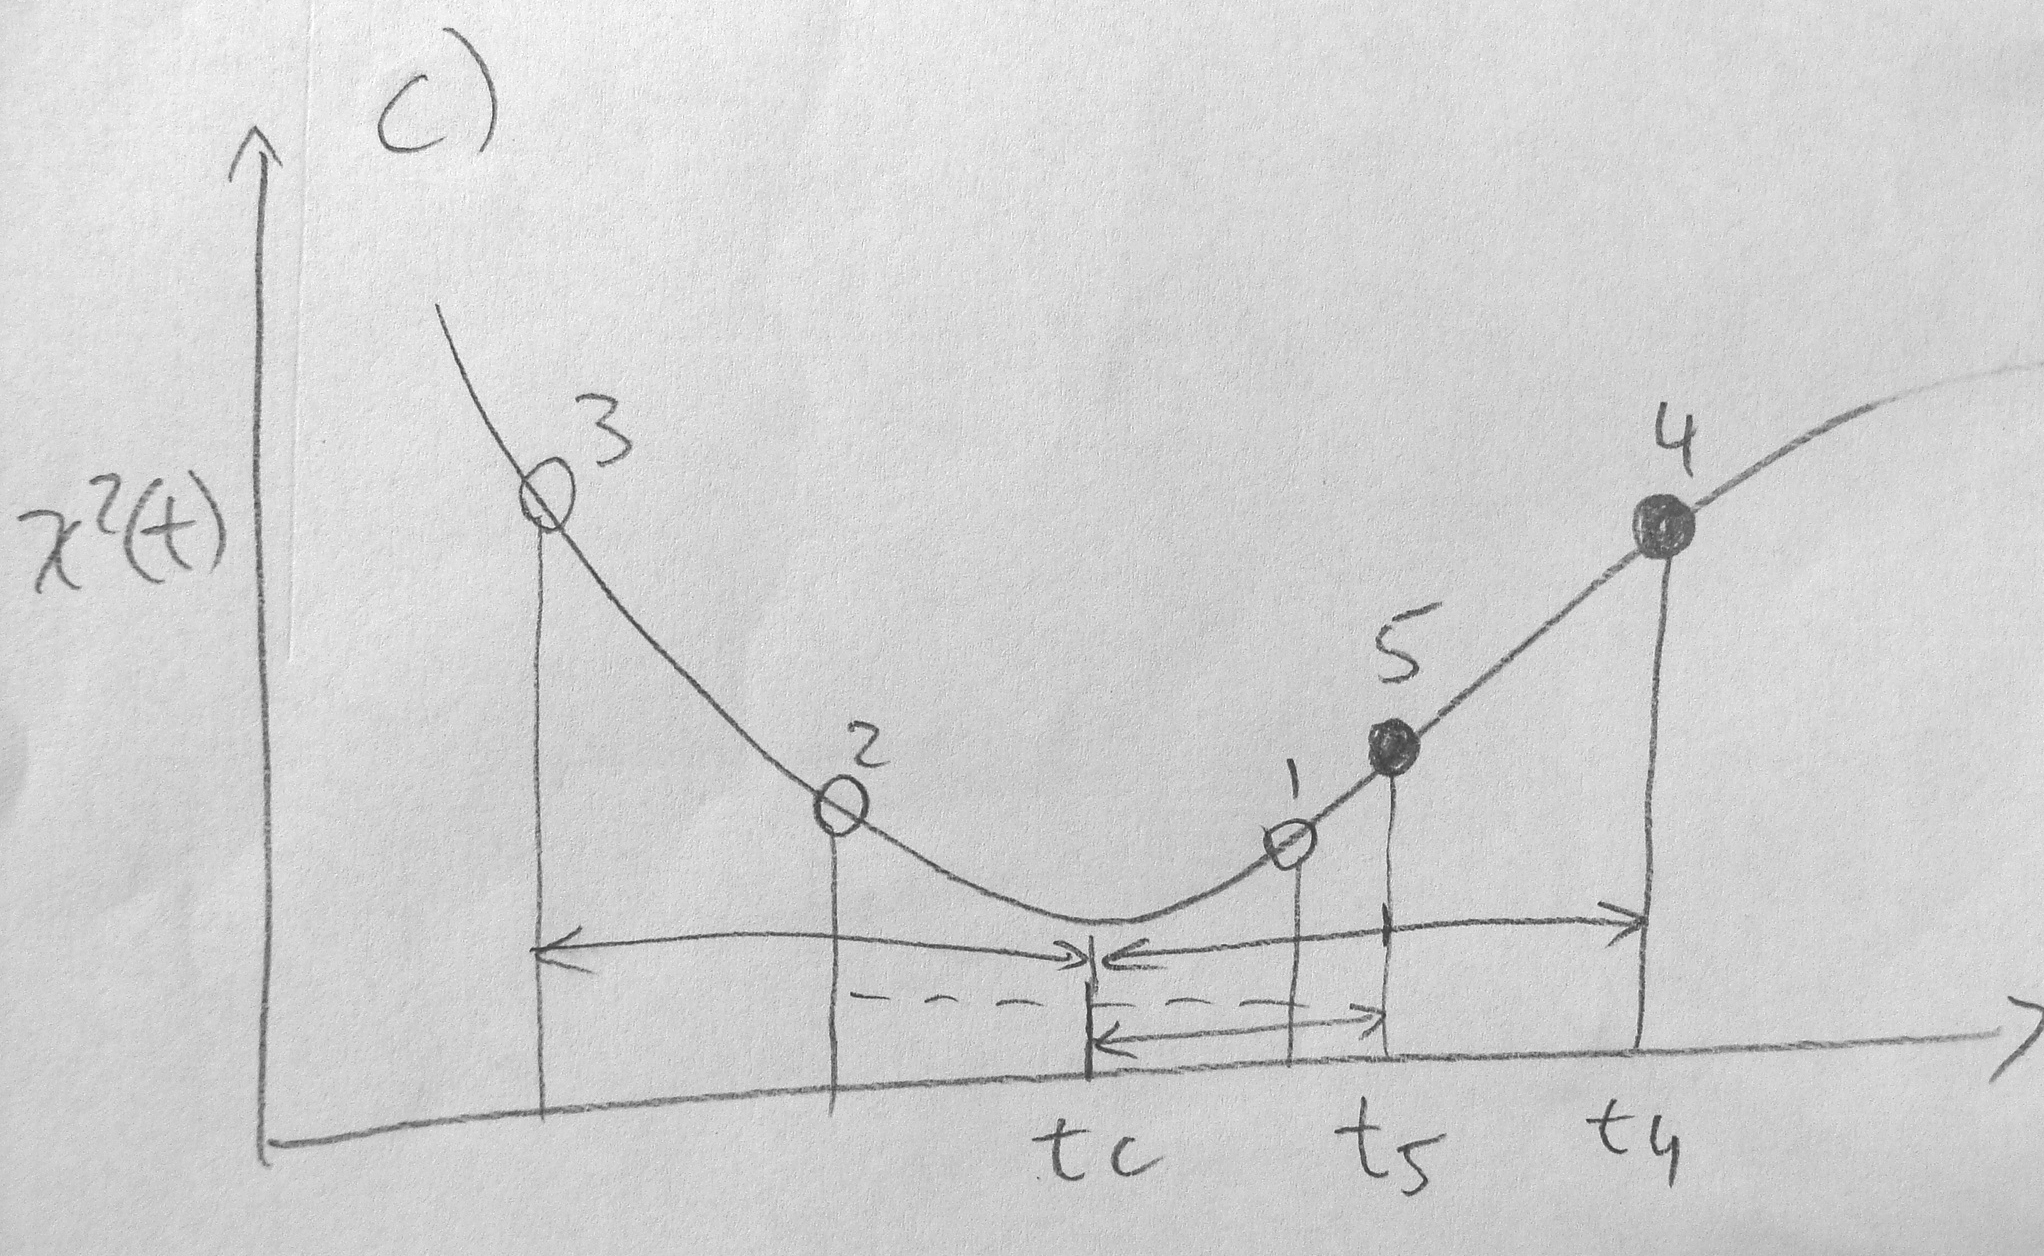

In [145]:
print 'Image credit: K. Poppenhaeger'
Image(filename='simplexC.JPG', width=800) 

**D)** If t4 is worse than t1, t2, and t3 (or if we're coming from option C and t5 is still worse than t1, t2, and t3): i.e. $\chi^2$(t1) < $\chi^2$(t2) < $\chi^2$(t3) < $\chi^2$(t4/5).

In that case we're pretty close to having found the best fit! Because the best fit is probably contained somewhere between t1 and t2. So we get all points closer by 50% to our best guess so far (which is t1) and start over. Specifically, we keep t1, move t2 and t3 closer to t1 by 50%, make a new simplex out of t1 and the new t2, and the new t3 is the new walking point. Start over at Step 2 (rename points accordingly).

Image credit: K. Poppenhaeger


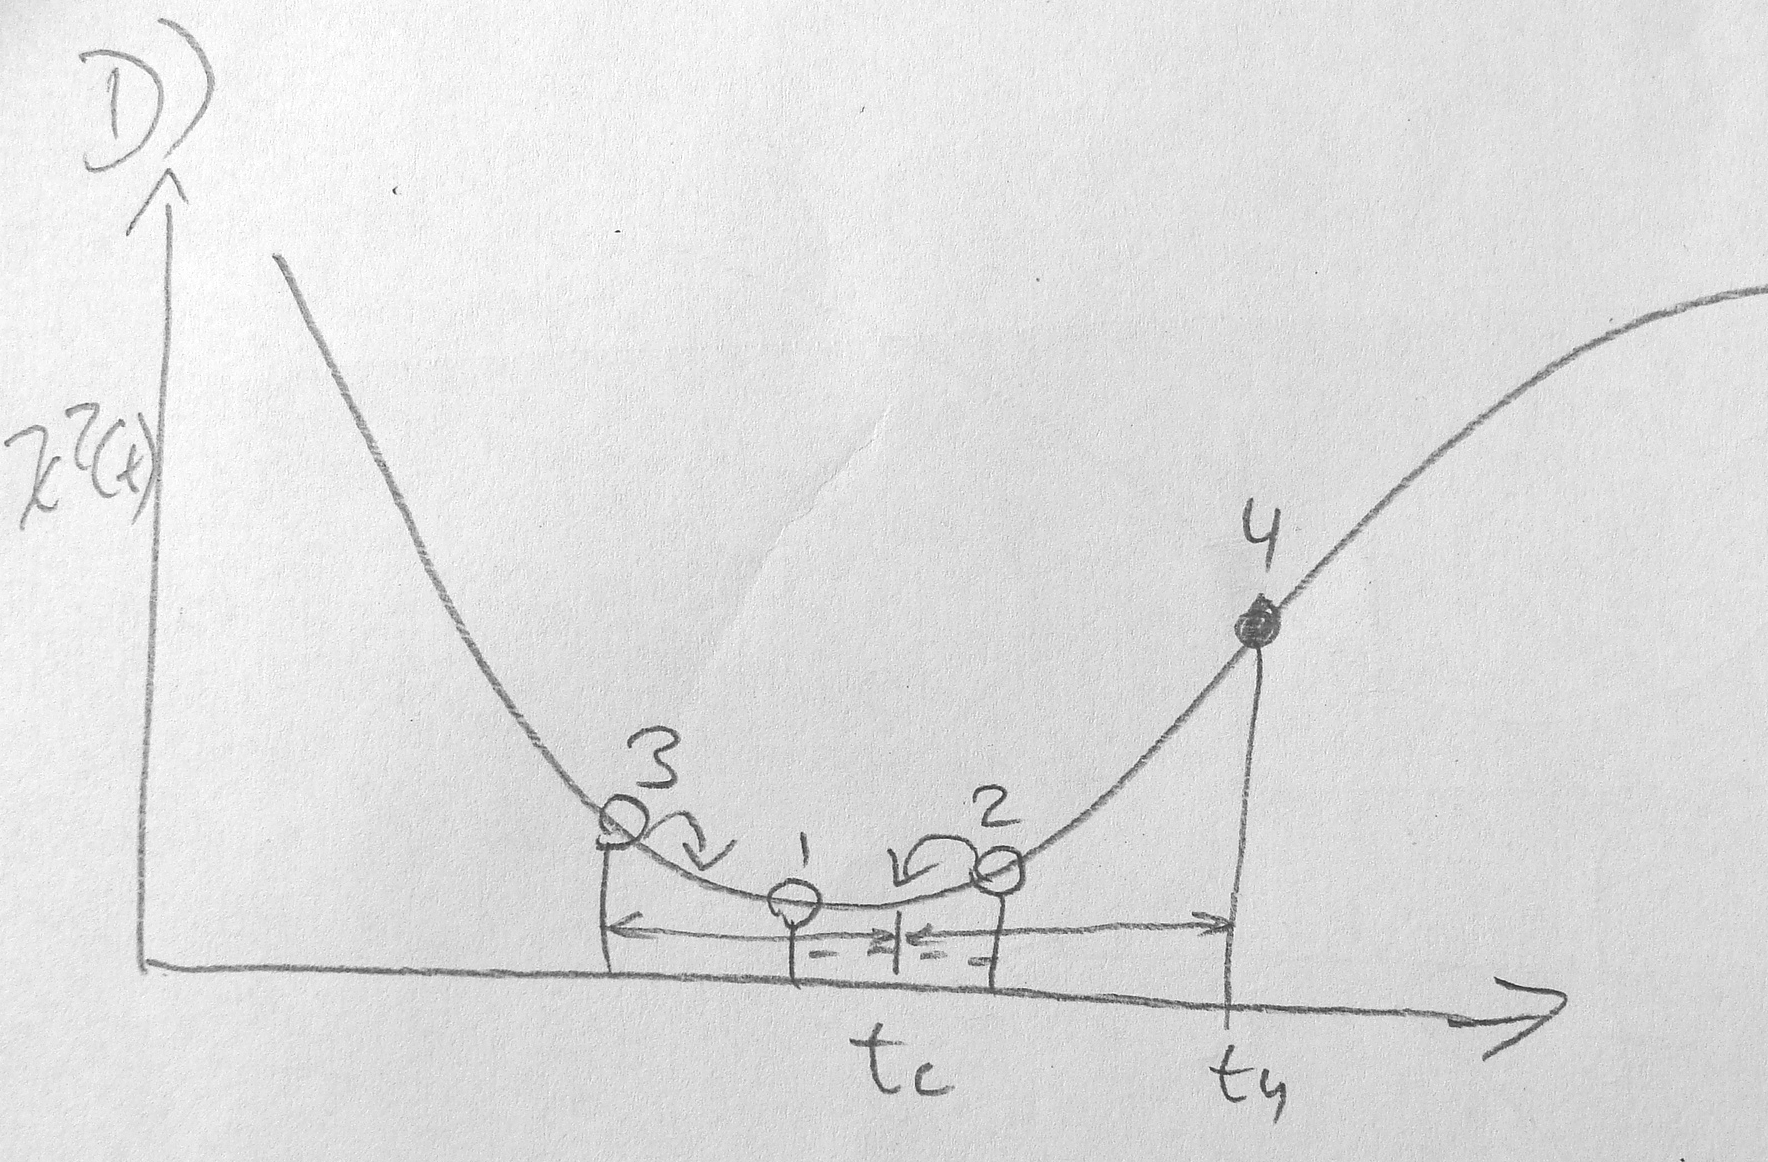

In [146]:
print 'Image credit: K. Poppenhaeger'
Image(filename='simplexD.JPG', width=800) 

**Stopping condition:** A typical way to tell the simplex algorithm when to stop is to give it the accuracy level to which we want our answer. So say we want to find the best fit for the transit start time with an accuracy of 0.01 time units, then as soon as we have a simplex where the difference between t1 and t2 is smaller than 0.01 time units, and that simplex goes to option D, we must be within less than 0.01 units of the correct answer. This is when the algorithm would stop.

## Worksheet materials

You may have guessed it: this week's worksheet problem is writing a function that performs a simplex fit.

We will use this as our chi-squared function and just pretend that it accurately gives us the goodnees of our fit of some function to some data (without worrying about the specifics of what the data and the model actually are):


In [151]:
def my_chi_func(t):
    return 800 + -t + 0.1*(t-600)**2


You can just copy and paste that into your own python editor.

Now, this chi-squared function has a minimum somewhere, and we want to find it. The brute-force way would be to calculate the value of that function for a lot of data points t, and plot it. We'll do that now just to see what we're dealing with here:

how many elements does this array have? 100000


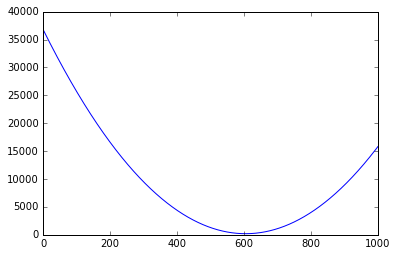

In [154]:
t = np.arange(0, 1000, 0.01)
print 'how many elements does this array have?', len(t)
y = my_chi_func(t) # so y has 100000 elements that we are calculating here!
plt.figure()
plt.plot(t, y)

Okay, so we see (as we are humans with real brains and pattern recognition and such) that there is a minimum at t=600. Now we want to make an algorithm that can find that minimum without having to calculate the value of the chi-squared function 100000 times like we did above for the plot.

Because programming a real simplex fitter is a bit complicated, I will give you some guidance and you will try to fill in the different cases for the test points until the function works!

This is the outline of the function:

**Note: for copy-paste to work properly, you should open the html version of these notes, not the pdf ones (pdf does weird things to the indentations when you try to copy-paste).**

In [159]:
def my_simplex_step(T1, T2, T3): # user supplies three random choices for T values
    # calculate chi-squared for the three guesses:
    chi1 = my_chi_func(T1)
    chi2 = my_chi_func(T2)
    chi3 = my_chi_func(T3)
    # now for the sorting:
    # put them together in an array:
    all_chi = np.array([chi1, chi2, chi3])
    # also put T guesses in an array:
    all_T = np.array([T1, T2, T3])
    # find where chi-squared is smallest; that T point will be called t1.
    # we do this with a boolean mask:
    smallest = all_chi == all_chi.min() # this is an array with three True/False values, and it is true at the position of the smalles chi-squared
    t1 = all_T[smallest]
    largest = all_chi == all_chi.max()
    t3 = all_T[largest]
    middle = (~smallest) & (~largest) #  "~" means NOT; i.e. this means NOT smallest AND NOT largest
    t2 = all_T[middle]
    
    # now we have to find the fourth point.
    # first calculate the centroid point (tc) which is in the middle between t1 and t2:
    
    # (your code here)
    
    # then we calculate the reflected point t4:
    
    # (your code here)
    
    # Now we have to make a comparison where the chi-squared for t4 falls in comparision to t1, t2, and t3.
    # It should go something like this:
    
    chi4 = my_chi_func(t4)
    
    # case A:
    if (chi4 > chi1) & (chi4 <= chi2):
        print "I'm calculating case A."
        # (your code here)
    
    # case B:
    elif chi4 <= chi1:
        print "I'm calculating case B."
        # (your code here)
    
    # case C:
    elif (chi4 > chi2) & (chi4 <= chi3):
        print "I'm calculating case C."
        # (your code here)
    
    else:
        print "I'm calculating case D."
        # (your code here)
    
    # now the points need to be re-named, and you have to return the new t1, t2, t3.
    return (t1, t2, t3)

This is the function for a single step of the simplex. Once this works to your satisfaction, write a second function that makes many simplex steps until the stopping condition is fulfilled. Here's an outline:

In [160]:
def my_simplex_manysteps(T1, T2, T3, stopping_accuracy): # user supplies three random choices for T values and the stopping accuracy
    # first step of the simplex walk:
    (t1, t2, t3) = my_simplex_step(T1, T2, T3)
    # calculate what the size of the t1-t2 simplex is (i.e. the distance between the two points):
    # size_of_simplex = (your code here)
    # now check if that size is smaller than the stopping accuracy; if not, make another simplex step.
    
    # at the end, you will want to print something like your best result, which will be the t1 you get in your final simplex step.
    print 'Best result:', t1
    return t1

In [161]:
my_simplex_manysteps(100., 200., 250., 10.)

I'm calculating case B.
Best result: [ 250.]


array([ 250.])

Just see how far you get with this, it's quite a fun exercise to build you own simplex fitter.

I hope you liked the PHY1024 module! Happy summer holidays to all of you.

Cheers,

Dr. Katja Poppenhaeger